# Abstract

Estimating future value of a customer is one of the core pillars in marketing strategy. Value can be perceived either by the net profit or revenue earned from a customer during a period of defined length in the future. A number of Econometric, Probabilistic and Machine Learning models utilize customer level transactions for this purpose. 

The modeling approach explored in this project is one amongst a suite of Bayesian probabilistic models popularly known as the Buy till you die models for estimating customer value. The report discusses the theory and application of a combination of Beta Geometric Negative Binomial Distribution (BG/NBD) model and the Gamma-Gamma submodel for estimating the expected future value of customers for an e-commerce retail business. The BG/NBD model was first introduced by Fader, Hardie and Lee in 2004 for predicting expected future transactions and survival probability for customers in a non-contractual setup. 

The model is trained over a calibration period of 9 months. The report assesses model efficacy through predictions made over a holdout period of 3 months. The model performance is evaluated against a simplistic baseline model based on the observed average behavior of an individual. Finally, the model is used to predict “High Future Value” customers and the lift obtained in capturing target customers is reported.


In [2]:
os.chdir("C:\\Users\\Hi\\Documents\\UC BANA Master\\Data science - Python\\Customer Lifetime Value Model\\UK Retailer - UCI ML Repo\\1. WIP")

# Introduction

Organizations are increasingly developing their arsenal of marketing tactics to drive customer centricity. This has led to an increased spending in marketing analytics and AI research to re-invent strategies for retention, acquisition and customer engagement. The CMO survey results report of February 2020[1] projects an increase of 8% in annual marketing spend in the Retail Industry. It is currently estimated to be ~ 12% of the total revenue earned.

At the centre of marketing research is Campaign Budget Optimization (CBO), which focusses on redistributing budget to target the high potential audience. Customer Lifetime Value (CLV) is an important metric used by marketers to identify such an audience. It is defined as the net present value of all the future cash flows generated by the customer over his/her “lifetime”. Typically, the “lifetime” duration is considered to be three years due to two reasons: (a) Product Lifecycle and, (b) 80% of profit comes in three years (Gupta and Lehman, 2006). However, this period can be defined as per marketing needs. In order to estimate CLV, the following questions need to be addressed:

* How many times is a customer expected to purchase in a given period in future?
* What will be the worth of these future purchases?
* What will be the total cost of making the sale?

For the scope of this project, the cost component is kept out of the computation due to data unavailability, and CLV is calculated based on expected revenue earned from customers. If data is available, the total cost can simply be subtracted from the expected revenue before adjusting for time value of money, without any change in the CLV modelling techniques.

In a non-contractual setting, a customer can be expected to drop out at any point in time. Therefore, a single definition of churn cannot be used to predict drop-out probability, which depends on, amongst other factors, the individual’s own frequency of purchase and the time of the last purchase. This point is illustrated with the plot below:

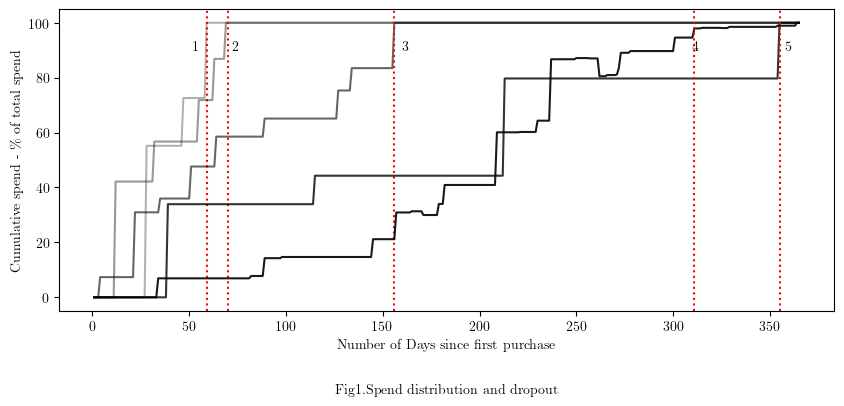

In [3]:
#Import image
from IPython.display import Image
Image(filename="Cumulative spend Distribution.png",width=800,height=600)

Customer 1 ceases activity within ~ 60 days from the first shop (cumulative spend reaches total spend), whereas customer 5 takes over 100 days within consecutive purchases and continues to stay alive till the 350th day. It is reasonable to assume that the probability of staying alive beyond the 350th day is much higher for customer 5 as compared to customer 1. The report discusses in detail the probabilistic models that account for these subtleties of customer buying pattern.

# Objective

The objective of this project is to demonstrate the application of Bayesian probabilistic and machine learning models to estimate future customer value. This involves predicting the expected count and value of transactions in a given period of time in the future for every customer. The models are designed for a non-contractual business, and assume that customer response is unsolicited i.e. no sales triggers are used in the calibration or holdout period. The probabilistic model discussed accounts for the fact that a customer has a certain probability of dropping out after every purchase.

# Python utilities

In [96]:
import pandas as pd, numpy as np, scipy, matplotlib as mpl,matplotlib.pyplot as plt,seaborn as sns,statsmodels.api as sm, \
lifetimes,sys,gc, os, warnings,IPython
warnings.filterwarnings('ignore')

In [108]:
from matplotlib import rc
from lifetimes.plotting import *
from lifetimes.utils import *
from scipy import stats
from scipy.stats import poisson

# Data

Typically e-commerce transaction-level datasets are proprietary and consequently unavailable in public domain for free. However, The UCI Machine Learning Repository has collected this dataset containing actual transactions from 2010 and 2011 for a UK-based and registered non-store online retailer. The company mainly sells unique all-occasion gifts. A majority of customers are wholesalers and small B2C businesses. The dataset is available for public access and can be found on UCI’s website by the title "Online Retail".

In [4]:
source = pd.read_csv("data.csv",encoding = "ISO-8859-1", engine='python')
print('Total customers in data: ',source['CustomerID'].nunique())
print('Total transactions in data: ',source[source['Quantity']>0]['InvoiceNo'].nunique())

Total customers in data:  4372
Total transactions in data:  20728


This data contains over 20k transactions occurring between 01/12/2010 and 09/12/2011. Information on individual data fields is tabulated below:

| Column name | Data type | Description | Non-missing values (%)
| --- | --- | --- | --- |
| InvoiceNo | Char | Unique Identifier for a transaction | 100
| StockCode | Char | Unique Identifier for an item in invoice | 100
| Description | Char | Item description | 99.7
| Quantity | Int | Item units purchased in an invoice | 100
| InvoiceDate | Char | Date of purchase | 100
| UnitPrice | Float | Per unit cost of item | 100
| CustomerID | Float | Unique Customer Identifer | 75
| Country | Char | Customer location | 100

# Exploratory Analysis

## Aggregate data for customer visits

A different date of transaction for a customer is considered a different "visit". All transactions made on a single date come under the same "visit".

In [72]:
# Create a copy of source data for working
df = source.copy()
# Remove records with missing customer IDs and order cancellation records
df['InvoiceDate'] = pd.to_datetime(pd.to_datetime(df['InvoiceDate'],format='%m/%d/%Y %H:%M').dt.date)
df = df[pd.notnull(df['CustomerID'])]
df = df[(df['Quantity']>0)]
df['Sales'] = df['Quantity'] * df['UnitPrice']
# Keep columns of interest
cols_of_interest = ['CustomerID', 'InvoiceDate', 'Sales']
df = df[cols_of_interest]
# Aggregate data
agg = df.groupby('CustomerID').agg({'InvoiceDate':'nunique','Sales':'sum'}). \
      reset_index()  
agg.columns = agg.columns.get_level_values(0)
agg.columns = ['CustomerID','CountVisits','TotalSales']
# Categorize customers based on visits
agg['CountVisitsBin'] = agg['CountVisits'].apply(lambda x: 'single visit' if x==1 else 'multiple visits')
agg['CountVisitsClusters'] = agg['CountVisits'].apply(lambda x: '1 visit' if x==1 \
                                                 else ('2-5 visits' if (2<=x) & (x<=5) \
                                                 else ('6-10 visits' if (6<=x) & (x<=10) \
                                                 else('11-20 visits' if (11<=x) & (x<=20) else 'gt20 visits'))))
                                                 
# Average Spend per visit
agg['AvgSpendPerVisit'] = agg['TotalSales']/agg['CountVisits']
agg.head()

,CustomerID,CountVisits,TotalSales,CountVisitsBin,CountVisitsClusters,AvgSpendPerVisit
0,12346.0,1,77183.60,single visit,1 visit,77183.600000
1,12347.0,7,4310.00,multiple visits,6-10 visits,615.714286
2,12348.0,4,1797.24,multiple visits,2-5 visits,449.310000
3,12349.0,1,1757.55,single visit,1 visit,1757.550000
4,12350.0,1,334.40,single visit,1 visit,334.400000


## Visits per customer

Probabilistic models can be used to model the expected number of visits in a given period for repeat buyers. 66% of the customers in the given dataset are repeat buyers. On average, repeat buyers have made >5 vists, but the variation of frequency is high across customers. The distribution for number of visits per customer can be modelled by a Poisson family distribution (Colombo and Jiang, 1999).

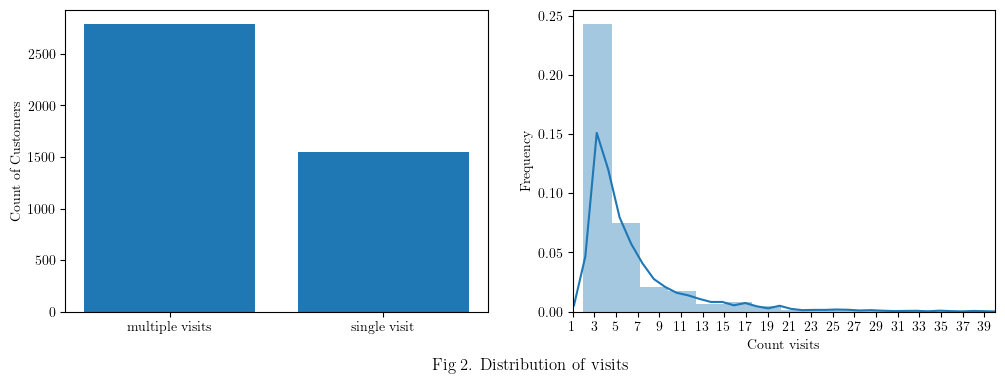

In [252]:
# Plot

mpl.rcParams['figure.dpi']= 100

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

plotdf1 = agg.groupby('CountVisitsBin')[['CustomerID']].nunique().reset_index()
fig,axe = plt.subplots(1,2,figsize = (12,4));
axe[0].bar(plotdf1['CountVisitsBin'],plotdf1['CustomerID']);
axe[0].set_ylabel("Count of Customers");

plotdf2 = agg[agg['CountVisitsBin'] == 'multiple visits']
sns.distplot(plotdf2['CountVisits'],ax=axe[1]);
axe[1].set_ylabel("Frequency");
axe[1].set_xlabel("Count visits");
axe[1].set_xlim([1,40]);
axe[1].set_xticks(np.arange(1,40,2));
plt.text(s="Fig 2. Distribution of visits",x=-12,y=-0.05,fontsize=12);
plt.savefig('output_23_0.pdf',bbox_inches="tight")

In [196]:
agg[agg['CountVisitsBin'] == 'multiple visits']['CountVisits'].describe()

count    2790.000000
mean        5.454122
std         6.930419
min         2.000000
25%         2.000000
50%         4.000000
75%         6.000000
max       132.000000
Name: CountVisits, dtype: float64

## Average spend per visit

Average spend per visit typically is in the range of [100,500] GBP (Please note that most customers are B2C businesses). Since spend data is bounded by 0 on the left and tends to be right skewed, gamma distribution is used as a prior distribution for modelling spend (Colombo and Jiang, 1999).

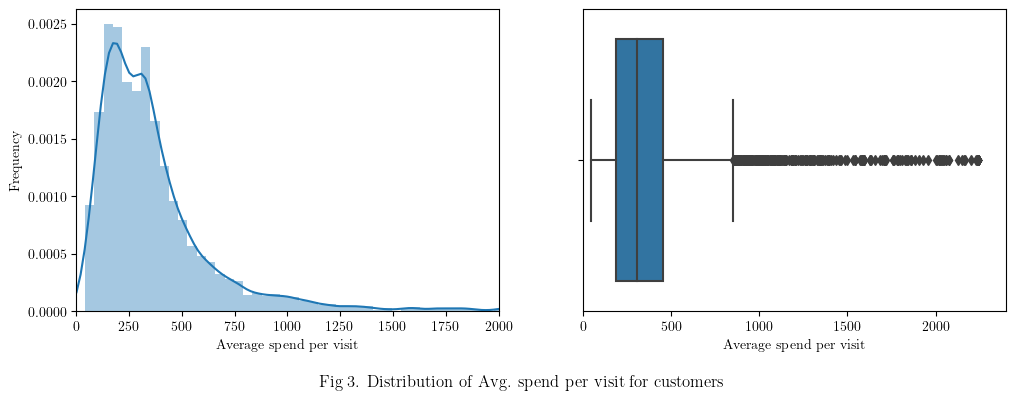

In [253]:
# Plot

mpl.rcParams['figure.dpi']= 100
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

plotdf1 = agg.copy()
percentiles = plotdf1['AvgSpendPerVisit'].quantile([0.01,0.99]).values
plotdf1['AvgSpendPerVisit'][plotdf1['AvgSpendPerVisit'] <= percentiles[0]] = percentiles[0]
plotdf1['AvgSpendPerVisit'][plotdf1['AvgSpendPerVisit'] >= percentiles[1]] = percentiles[1]

fig,axe = plt.subplots(1,2,figsize=(12,4));
sns.distplot(plotdf1['AvgSpendPerVisit'],ax=axe[0]);
axe[0].set_xlim([0,2000]);
axe[0].set_ylabel("Frequency");
axe[0].set_xlabel("Average spend per visit");
sns.boxplot(plotdf1['AvgSpendPerVisit'],ax=axe[1]);
axe[1].set_xlim([0,2400]);
axe[1].set_xlabel("Average spend per visit");
plt.text(s="Fig 3. Distribution of Avg. spend per visit for customers",x=-1500,y=0.75,fontsize=12);
plt.savefig('output_27_0.pdf',bbox_inches="tight")

### Analyze spend over subsequent visits

In [255]:
# Create column for sequence of visits
agg_0 = df.groupby(['CustomerID','InvoiceDate'])[['Sales']].sum().reset_index().rename(columns={'Sales':'VisitSpend'})
agg_0.sort_values(by=['CustomerID','InvoiceDate'],ascending=[True,True],inplace=True)
agg_0['visitsequence'] = agg_0.groupby('CustomerID')['InvoiceDate'].rank("dense",ascending=True)
# Cap/remove outliers
percentiles = agg_0['VisitSpend'].quantile([0.01,0.99]).values
agg_0['VisitSpend'][agg_0['VisitSpend'] <= percentiles[0]] = percentiles[0]
agg_0['VisitSpend'][agg_0['VisitSpend'] >= percentiles[1]] = percentiles[1]
# Map count visits cluster
agg_0 = agg_0.merge(agg[['CustomerID','CountVisitsClusters']],how='left',on='CustomerID')
# Calculate average spend for nth transaction
plotdf1 = agg_0.groupby(['visitsequence','CountVisitsClusters'])[['VisitSpend']].mean().reset_index().rename(columns={'VisitSpend':'AvgVisitSpend'})
plotdf1 = plotdf1[plotdf1['CountVisitsClusters'] != '1 visit']

The plot below shows no observable trend in average spend as customers make subsequent visits. This behavior is observed across customer segments based on frequency of visits.

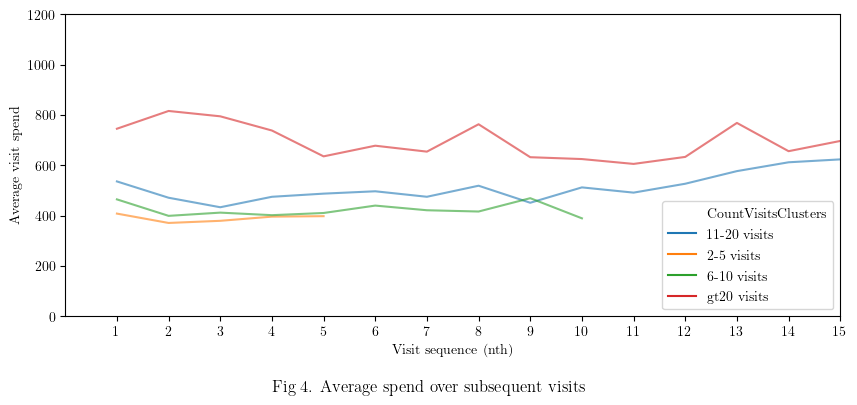

In [258]:
# Plot
mpl.rcParams['figure.dpi']= 100
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

plt.figure(figsize=(10,4))
sns.lineplot(x=plotdf1["visitsequence"], y=plotdf1["AvgVisitSpend"],hue=plotdf1['CountVisitsClusters'],linewidth=1.5,alpha=0.6);
plt.ylabel('Average visit spend');
plt.xlabel('Visit sequence (nth)');
plt.xlim([0,15]);
plt.ylim([0,1200]);
plt.xticks(np.arange(1,16,1));
plt.text(s="Fig 4. Average spend over subsequent visits",x=4,y=-300,fontsize=12);
plt.savefig('output_31_0.pdf',bbox_inches="tight")

## Visit cycle

Typically customers place a subsequent order within 30-45 days from the previous purchase, and 75% of the population makes under 1.2 orders per month. The below table shows the statistics of the gap (in days) between orders at a customer level. The plot shows average number of orders per month across customer segments based on total transactions in the given data. Therefore, a period of 1 month can be taken as a suitable unit for inter-arrival time. This will later on be important in determining the length of observation and holdout periods for the Bayesian model.

In [86]:
# Calculate visit frequency for repeat buyers
custrec = agg_0.groupby('CustomerID').agg({'InvoiceDate':['nunique','max','min']}).reset_index()
custrec.columns = custrec.columns.get_level_values(0)
custrec.columns = ['CustomerID','CountVisits','MaxDate','MinDate']
custrec['Recency'] = (custrec['MaxDate'] - custrec['MinDate'])/np.timedelta64(1, 'M')
custrec['VisitsPerMonth'] = custrec['CountVisits']/custrec['Recency']
custrec[custrec['CountVisits']>1]['VisitsPerMonth'].describe()

count    2790.000000
mean        1.396369
std         4.088515
min         0.166322
25%         0.463506
50%         0.707834
75%         1.217475
max        60.873750
Name: VisitsPerMonth, dtype: float64

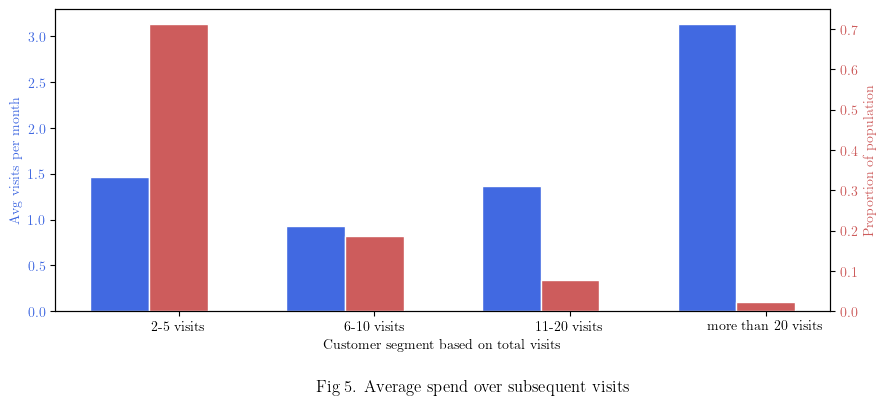

In [259]:
# Plot
custrec = custrec[custrec['CountVisits']>1]
plotdf1 = custrec.merge(agg[['CustomerID','CountVisitsClusters']],how='left',on='CustomerID')
plotdf1 = plotdf1.groupby('CountVisitsClusters').agg({'VisitsPerMonth':'mean','CustomerID':'nunique'}).reset_index()
plotdf1.columns = plotdf1.columns.get_level_values(0)
plotdf1.columns = ['CountVisitsClusters','AvgVisitsPerMonth','CustomerCount']
plotdf1['totalcust'] = plotdf1['CustomerCount'].sum()
plotdf1['Segmentpopulation'] = plotdf1['CustomerCount']/plotdf1['totalcust']
plotdf1['rank'] = pd.Series(np.array([3,1,2,4]))
plotdf1.sort_values(by='rank',ascending=True,inplace=True)

mpl.rcParams['figure.dpi']= 100
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
#set bar width
barwidth = 0.3
#Set subplot axis - ax1
fig,ax1 = plt.subplots(figsize=(10,4));
ax1.set_xlabel('Customer segment based on total visits');
ax1.set_ylabel('Avg visits per month',color='royalblue');
#set positions of bars on x-axis
r1 = np.arange(len(plotdf1[['CountVisitsClusters']]))
r2 = [x+barwidth for x in r1]
#Make the primary axis plot - ax1
avgorderplot = ax1.bar(r1, 'AvgVisitsPerMonth', data=plotdf1, color = 'royalblue', edgecolor = 'white', width = barwidth);
ax1.tick_params(axis='y',labelcolor = 'royalblue');
#Configure the x-axis tick marks : positions and labels of major ticks
ax1.set_xticks([r + barwidth for r in np.arange(len(plotdf1[['CountVisitsClusters']]))]);
ax1.set_xticklabels(['2-5 visits', '6-10 visits', '11-20 visits', 'more than 20 visits']);
#Set the secondary axis ax2 - that uses the same x-axis
ax2 = ax1.twinx();
ax2.set_ylabel('Proportion of population',color='indianred');
#Make the secondary axis plot - ax2
proportionplot = ax2.bar(r2, 'Segmentpopulation', data=plotdf1, color = 'indianred', edgecolor = 'white', width = barwidth);
ax2.tick_params(axis='y',labelcolor = 'indianred');

plt.text(s="Fig 5. Average spend over subsequent visits",x=1,y=-0.2,fontsize=12);
plt.savefig('output_35_0.pdf',bbox_inches="tight")

## RFM metrics

Recency, Frequency and Monetary metrics are key inputs to predicting future purchases and drop-out probability of a customer at any point in time. Further sections of the report would discuss in detail the theory behind the use of RFM data for probabilistic models. In the context of CLV modelling, the RFM metrics are defined as follows:

* Recency: Number of time periods elapsed (days in this case) between the first and the last visit of a customer
* Frequency: Number of repeat visits
* Monetary: Average spend value per visit for repeat visits

"T" is the total observation period for a customer - from the date of first visit to the end of observation period

In [99]:
rfmdata = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-09')
rfmdata.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


50% of the customers have less than or equal to 1 repeat visit in the data. Summary of Recency and Frequency metrics calculated for the entire dataset is tabulated below:

In [100]:
rfmdata.describe()

,frequency,recency,T,monetary_value
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,2.864024,130.741415,222.782899,306.944168
std,5.952745,132.210176,117.883623,2612.453380
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,112.000000,0.000000
50%,1.000000,93.000000,248.000000,176.940000
75%,3.000000,252.000000,326.000000,360.161667
max,131.000000,373.000000,373.000000,168469.600000


The Monetary and Frequency metrics do not show strong linear correlation with each other as can be seen in the plot below. Recency and Frequency display non-linear correlation. Customers with a high frequency have typically made a visit in the recent past. 
Please note that higher recency values indicate that the customer has made a purchase more recently (with reference to 09/12/2011 as end date for the observation period). Customers with high frequency and low recency values have a lower probability of being alive by the end of the observation period.

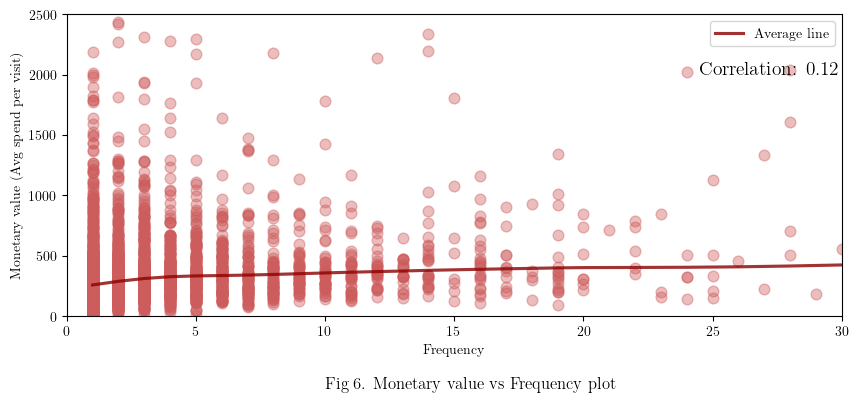

In [260]:
# Plot
mpl.rcParams['figure.dpi']= 100
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

plotdf1 = rfmdata[rfmdata['frequency']>0]
plt.figure(figsize=(10,4))
sns.regplot(x=plotdf1["frequency"], y=plotdf1["monetary_value"], fit_reg=True,lowess=True, scatter_kws={"color":"indianred","alpha":0.4,"s":60},line_kws={"color":"darkred","alpha":0.8,"label":"Average line"});
plt.ylabel('Monetary value (Avg spend per visit)');
plt.xlabel('Frequency');
plt.legend();
plt.xlim([0,30]);
plt.ylim([0,2500]);
plt.annotate("Correlation: 0.12",xy=(24.5,2000),fontsize=14);
plt.text(s="Fig 6. Monetary value vs Frequency plot",x=10,y=-600,fontsize=12);
plt.savefig('output_42_0.pdf',bbox_inches="tight")

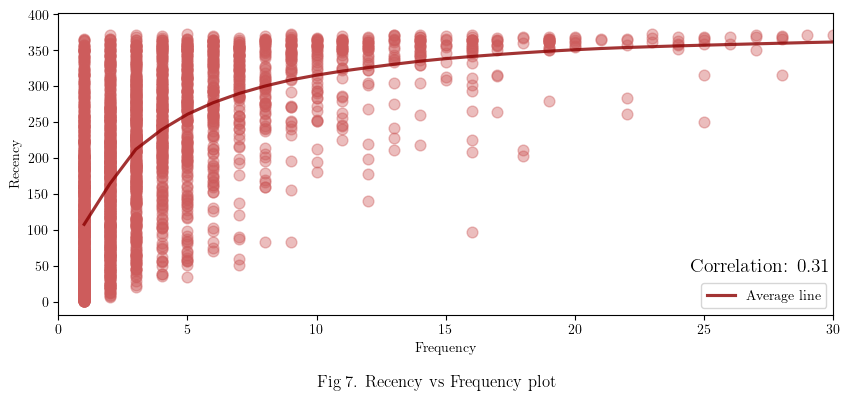

In [263]:
# Plot
mpl.rcParams['figure.dpi']= 100
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

plotdf1 = rfmdata[rfmdata['frequency']>0]
plt.figure(figsize=(10,4))
sns.regplot(x=plotdf1["frequency"], y=plotdf1["recency"], fit_reg=True,lowess=True, scatter_kws={"color":"indianred","alpha":0.4,"s":60},line_kws={"color":"darkred","alpha":0.8,"label":"Average line"});
plt.ylabel('Recency');
plt.xlabel('Frequency');
plt.legend();
plt.xlim([0,30]);
plt.annotate("Correlation: 0.31",xy=(24.5,42),fontsize=14);
plt.text(s="Fig 7. Recency vs Frequency plot",x=10,y=-120,fontsize=12);
plt.savefig('output_43_0.pdf',bbox_inches="tight")

# BG/NBD Model - Theory

The Beta Geometric/Negative Binomial Distribution (BG/NBD) model is a Bayesian inference model introduced in 2004 by Fader, Hardie and Lee as an improvement of the Pareto/NBD model developed by Schmittlein et al. in 1987. The BG/NBD model belongs to the class of "Buy Till You Die" probabilistic models that help in projecting the future value of a customer by assessing the expected number of his/her future transactions and the probability of being "alive" beyond any transaction. Please note that the words "Visit" and "Transaction" are used interchangeably in this context and have the same meaning.

## Assumptions

The BG/NBD model is based on the following assumptions:

i) While active, the number of transactions made by a customer follows a Poisson process with transaction rate $\lambda$. This is equivalent to assuming that the time between transactions is distributed exponentially with transaction rate $\lambda$, i.e.,

\begin{equation}
f(t_{j}|t_{j-1};\lambda) = \lambda e^{-\lambda(t_{j} - t_{j-1})}
\end{equation}

ii) Heterogeneity exists in $\lambda$, i.e. each customer has his/her own transaction rate. This intrinsic $\lambda$ is unknown for a customer and is considered a latent random variable. The model assumes that $\lambda$ follows a gamma prior with pdf:

\begin{equation*}
f(\lambda |r,\alpha) = \frac{\alpha^r\lambda^{r-1}e^{-\lambda\alpha}}{\Gamma (r)}  , \lambda > 0.
\end{equation*}

r is the shape parameter and $\alpha$ is the scale parameter.

iii) After any transaction, a customer becomes inactive with probability p. Therefore the point at which the customer “drops out” is distributed across transactions according to a (shifted) geometric distribution with pmf

\begin{equation*}
P \left(inactive \, immediately \, after \, j^{th} \, transaction \right) = p(1-p)^{j-1} ,  j = 1,2,3,..
\end{equation*}

iv) Heterogeneity exists in p. Similar to $\lambda$, p is a latent random variable and follows a Beta prior with pdf:

\begin{equation*}
f(p|a,b) = \frac{p^{a-1}(1-p)^{b-1}}{B(a,b)},  0 \leq p \leq 1.
\end{equation*}

Where B(a,b) is the beta function, which can be expressed in terms of gamma functions:

\begin{equation*}
B(a,b) = \frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)}
\end{equation*}

v) The transaction rate $\lambda$ and the dropout probability p vary independently across customers.

<br>
To better illustrate the assumptions, the below plots show: 

(left) poisson distributions simulated for 10 customers where each $\lambda$ is randomly chosen from a Gamma distribution
(right) Geometric distribution of drop-out probability simulated for 10 customers where each p is randomly chosen from a Beta distribution


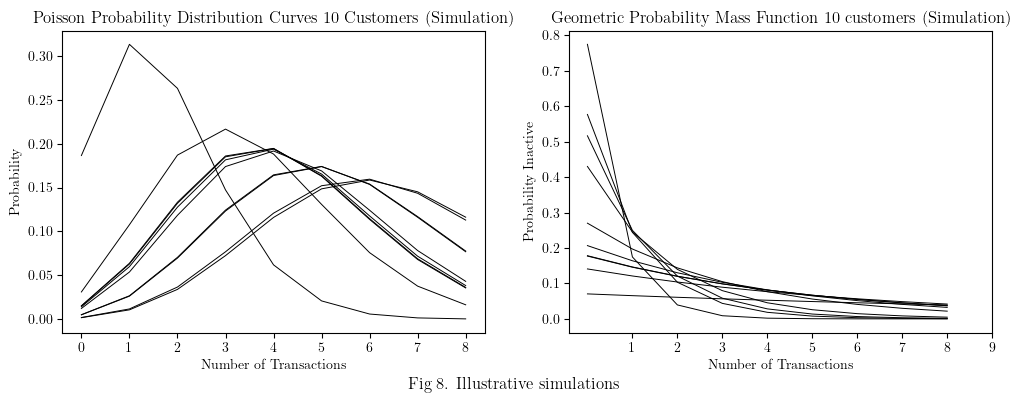

In [264]:
# Plot

mpl.rcParams['figure.dpi']= 100
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

fig,ax = plt.subplots(1,2,figsize=(12,4));

gamma_shape = 9
gamma_scale = 0.5

for customer in range(0, 10):
    distribution = poisson(np.random.gamma(shape=gamma_shape, scale=gamma_scale))
    p_arr = []
    for transactions in range(0,9):
        p_arr.append(distribution.pmf(transactions))
    ax[0].plot(p_arr, color='black', linewidth=0.7, zorder=1);
    
ax[0].set_ylabel('Probability');
ax[0].set_xlabel('Number of Transactions')
ax[0].set_xticks(range(0,9))
ax[0].set_title('Poisson Probability Distribution Curves 10 Customers (Simulation)');


beta_a = 2
beta_b = 3

for cust in range(0, 10):
    pr_arr = []
    beta = np.random.beta(a=beta_a, b=beta_b)
    for tran in range(1,10): 
        proba_inactive = beta*(1-beta)**(tran-1)
        pr_arr.append(proba_inactive)
    pr_arr = np.array(pr_arr)
    ax[1].plot(pr_arr, color='black', linewidth=0.7, zorder=1);

ax[1].set_ylabel('Probability Inactive')
ax[1].set_xlabel('Number of Transactions')
ax[1].set_xticks(range(1, 10))
ax[1].set_title('Geometric Probability Mass Function 10 customers (Simulation)');
plt.text(s="Fig 8. Illustrative simulations",x=-4,y=-0.2,fontsize=12);
plt.savefig('output_49_1.pdf',bbox_inches="tight")

## Outputs

Consider a customer who had x transactions in the period (0,T] with the transactions occurring at $t_{1}$, $t_{2}$, ...,$t_{x}$ as shown below:

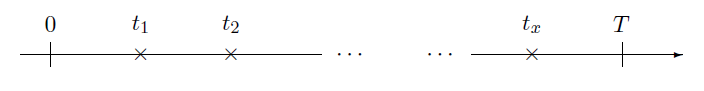

In [113]:
#Import image
from IPython.display import Image
Image(filename="Transactionprocess.PNG",width=800,height=200)

Eventually, by fitting the previously mentioned distributions on the historical customers data we are able to derive a model that for each customer provides:

* The probability of observing x transactions in a time period of length t as:

\begin{equation*}
P(X(t) \, = x|\lambda,p) = (1-p)^{x}\frac{(\lambda t)^{x}e^{-\lambda t}}{x!} + \delta_{x>0}p(1-p)^{x-1} \left[1-e^{-\lambda t} \sum_{j=0}^{x-1} \frac{(\lambda t)^j}{j!} \right]
\end{equation*}

* The expected number of transactions in a time period of length t as:

\begin{equation*}
E(X(t)|\lambda,p) = \frac{1}{p} - \frac{e^{-\lambda pt}}{p}
\end{equation*}

* The probability of a customer becoming inactive at period $\tau$ as:

\begin{equation*}
P(\tau > t) = e^{-\lambda pt}
\end{equation*}

The fitted distributions parameters are then used in the forward-looking customer-base analysis to find the **expected number of transactions in a future period of length t for an individual with past observed behavior defined by x, $t_x$, T** — where x = number of historical transactions, $t_x$ = time of last purchase and T = Age of a customer (Time between first visit to the end of observation period). Derivation of the below formula is present in the Appendix of P. Fader's Paper.

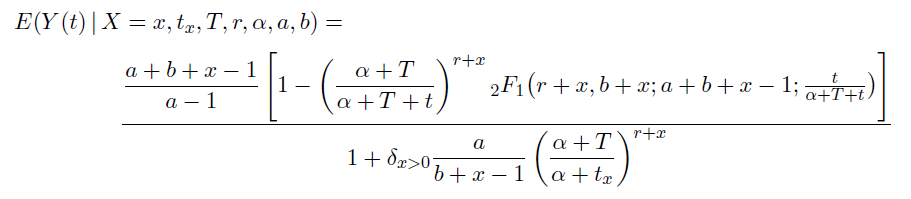

In [116]:
#Import image
from IPython.display import Image
Image(filename="Finalmodelequation.PNG",width=700,height=200)

The four BG/NBD model parameters (*r*,*$\alpha$*,*a*,*b*) can be estimated from data via the method of maximum likelihood. The sample log-likelihood function given below can be maximized by standard numerical optimization routines.

\begin{equation*}
LL(r,\alpha ,a,b) = \sum_{i=1}^{N} \ln \left [L(r,\alpha ,a,b \,| \,X_i = x_i ,t_{x_i}, T_i ) \right ]
\end{equation*}



**The above model needs the total visits (x), recency (t_x) and the observation duration (T) values for each customer**

# Gamma-Gamma Model - Theory

The Gamma-Gamma submodel is used to estimate the average monetary value of transactions for a customer. This model was first presented in Fader et al. (2005) and the detailed derivations are shown in Fader, Hardie (2013). 

For a customer with x transactions, let $z_1,z_2,...z_x$ denote the value of each transaction. The customer's observed average transaction is represented by:

\begin{equation*}
\bar{z} = \sum_{i=1}^{x}z_{i}/x
\end{equation*}

$\bar{z}$ is an imperfect estimate of their (unobserved) mean transaction value $\zeta$. The goal of the Gamma-Gamma submodel is to make inferences about $\zeta$ given $\bar{z}$, which is denoted as E(Z|$\bar{z}$,x) 

## Assumptions

The spend model is based on the following assumptions:

i) Average transaction value $\bar{z}$ varies across customers but does not vary over time for any individual customer

ii) The monetary value of a customer's given visit varies randomly around their average visit spend

iii) The distribution of the average visit spend across customers is indepedent of the transaction process

Furthermore, the following assumptions are made about the distribution of spend:

i) It is assumed that $z_i$ \~ Gamma(p,$\nu$), with E($Z_i$|p,$\nu$) = $\zeta$ = p/$\nu$

ii) For heterogeneity across customers, we assume that $\nu$ \~ gamma(q,$\gamma$)

## Outputs

Finally the objective is to make inferences about an individual customer's $\zeta$ given $\bar{z}$ where $\bar{z}$ itself follows the below distribution given p,q,$\gamma$; x. (Note: the parameters p,q,$\gamma$ are estimated from the data):

\begin{equation*}
f(\bar{z}|p,q,\gamma;x) = \frac{1}{\bar{z}B(px,q)}(\frac{\gamma}{\gamma + x\bar{z}})^{q}(\frac{x\bar{z}}{\gamma + x\bar{z}})^{px}
\end{equation*}

The final result is derived to be as follows:

\begin{equation*}
E(Z|p,q,\gamma;\bar{z},x) = (\frac{q-1}{px+q-1})\frac{p\gamma}{q-1} + (\frac{px}{px+q-1})\bar{z}
\end{equation*}

Please see the paper for complete derivation. This is called the conditional expectation of the customer's inherent mean transaction value - which is a latent variable. The point to note here is that as the number of visits x of customer increases, the formula places more weight on the customer's observed average spend.


**The above formula needs the number of visits (x) and the Monetary ($\bar{z}$) values for each customer**





**Expected future value = Expected number of visits in future period (using BG/NBD model) *x* Expected spend per visit (using Gamma-Gamma model)**



# Model Implementation

The *lifetimes* module in python is used for implementing the BG/NBD and Gamma-Gamma models. The input dataset needs to provide the **Recency**, **Frequency** and **Monetary** metrics for each customer along with the duration of the observation period. The remaining model parameters are estimated from the data.

The entire timeline of the dataset is divided into a Calibration period and a Holdout period. Ideally the length of calibration duration should be kept a minimum  of 5-10 times the visit cycle. As discussed in the EDA, the typical visit cycle for customers is 30-45 days. Keeping this in mind, the calibration period is taken up to $8^{th}$ August 2011. The Holdout period spans from $9^{th}$ August to $9^{th}$ December (3 months). This means that model parameters are estimated from the transactions of all customers who have visited till $8^{th}$ August 2011. Then each customer's expected visits and average spend is projected for the holdout period. The projected values are compared with the actual values in the holdout period for model validation. Projected values are also compared against a **baseline** projection made by using average values per unit time. 

## Caliberation and holdout data creation

In [205]:
# Filter transactions for customers who visited in the calibration period
customers = pd.DataFrame(df[df['InvoiceDate']<pd.to_datetime('2011-08-08',format='%Y-%m-%d')]['CustomerID'].unique(),columns=['CustomerID'])
input_tran = df.groupby(['CustomerID','InvoiceDate'])[['Sales']].sum().reset_index().merge(customers,how='inner',on='CustomerID')
# Summarize transactions into RFM metrics
from lifetimes.utils import calibration_and_holdout_data
summary_df = calibration_and_holdout_data(input_tran, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-08-08',
                                        observation_period_end='2011-12-09',
                                         monetary_value_col='Sales')    
# Remove customers who visited only once in the calibration period
summary_df = summary_df[summary_df['frequency_cal'] >0]
print(summary_df.head())

            frequency_cal  recency_cal  T_cal  monetary_value_cal  \
CustomerID                                                          
12347.0               4.0        238.0  244.0            519.7675   
12348.0               2.0        110.0  235.0            297.2200   
12352.0               3.0         34.0  173.0            421.7700   
12356.0               1.0         80.0  202.0            481.4600   
12359.0               2.0        142.0  208.0           1474.1150   

            frequency_holdout  monetary_value_holdout  duration_holdout  
CustomerID                                                               
12347.0                   2.0              759.570000               123  
12348.0                   1.0              310.000000               123  
12352.0                   3.0              314.743333               123  
12356.0                   1.0               58.350000               123  
12359.0                   1.0             2876.850000               123 

## Fit BG/NBD model for predicting expected visits in future

In [206]:
# Import model
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix
# Fit Model
bgnbd = BetaGeoFitter(penalizer_coef=0.0)
bgnbd.fit(summary_df['frequency_cal'], summary_df['recency_cal'], summary_df['T_cal'],verbose=True)

Optimization terminated successfully.
         Current function value: -2.590181
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30


<lifetimes.BetaGeoFitter: fitted with 1786 subjects, a: 0.02, alpha: 119.36, b: 0.16, r: 2.38>

## Assess model fit

The fitted model parameters are used to simulate a distribution for the calibration visit frequency. This distribution is then compared with the actual distribution. The below plot shows that the estimated model parameters closely resembles the real distribution for all visit frequency segments except 0. Please note that customers with 0 repeat frequency were filtered out for training.

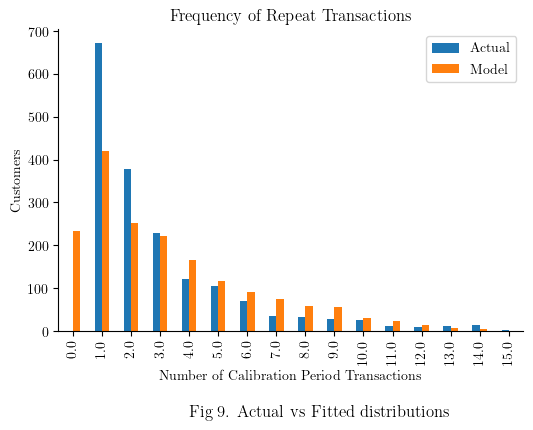

In [265]:
# Plot
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100
ax = plot_period_transactions(bgnbd, max_frequency=15);
sns.despine();
plt.text(s="Fig 9. Actual vs Fitted distributions",x=4,y=-200,fontsize=12);
plt.savefig('output_71_0.pdf',bbox_inches="tight")

In [176]:
#Predict purchases for the calibration duration
cal_df = summary_df[['frequency_cal','recency_cal','T_cal']]
cal_df['actual_calibration_visits'] = cal_df['frequency_cal']+1
cal_df['predicted_calibration_visits'] = bgnbd.predict(cal_df['T_cal'],cal_df['frequency_cal'],cal_df['recency_cal'],cal_df['T_cal'])
# Calculate RMSE of predictions
import math
a1 = np.array(cal_df['actual_calibration_visits'])
a2 = np.array(cal_df['predicted_calibration_visits'])
print('The RMSE for predictions in calibration period is: ',np.around(math.sqrt(np.mean(np.square(np.subtract(a1,a2)))),decimals=2))

The RMSE for predictions in calibration period is:  1.97


### Probability of being alive by customer recency and frequency

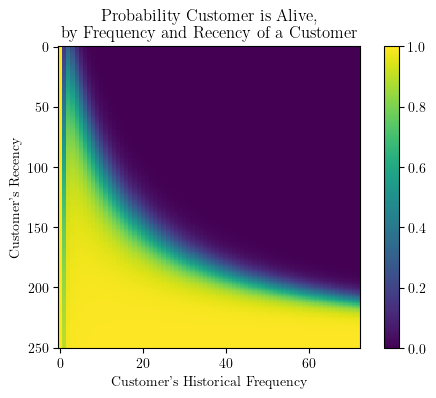

In [266]:
from lifetimes.plotting import plot_probability_alive_matrix
plot_probability_alive_matrix(bgnbd);
plt.savefig('output_74_0.pdf',bbox_inches="tight")

Below are the possible interpretations of the plot:

1. **Customers with low frequency and low recency values**: These customers are relatively young i.e. they have entered the system recently. They have made a few repeat visits over a short duration and are most likely alive.


2. **Customers with low frequency and high recency values**: These customers space out their purchases over time i.e they have longer purchase cycles. They have made a visit recently and are likely to come back again in some time.


3. **Customers with high frequency and high recency values**: These are the most active customers who have also visited recently. They are most likely alive.


4. **Customers with very high frequency but low recency values (i.e. no recent visits)**: These customers have made frequent visits in the past but have not visited in the recent past. They are most likely to have dropped out.

### Survival probability with time

The below plot generates the probability of being alive with visits made across time for a selected customer. This illustrates how the probability decreases if a repeat visit is not made as per the historic visit cycle. However, once a customer makes a visit he is considered "alive".

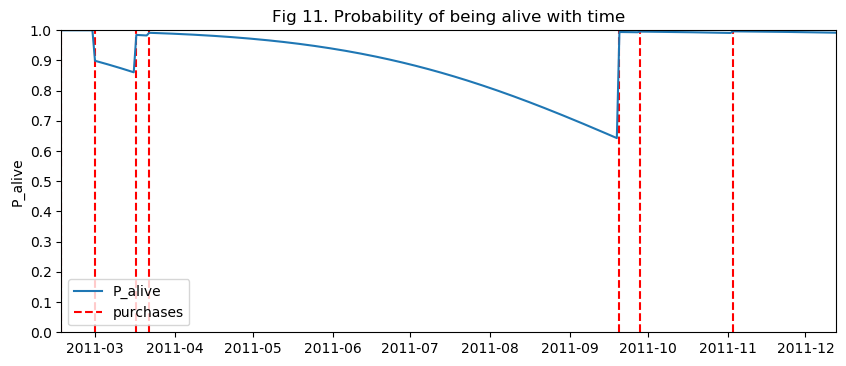

In [270]:
from lifetimes.plotting import plot_history_alive
mpl.rcParams['figure.dpi']= 100
rc('text', usetex=False)
fig = plt.figure(figsize=(10,4))
days_since_birth = 300
sp_trans = input_tran.loc[input_tran['CustomerID'] == 12352.0]
plot_history_alive(bgnbd, days_since_birth, sp_trans, 'InvoiceDate');
plt.title("Fig 11. Probability of being alive with time");
plt.savefig('output_78_1.pdf',bbox_inches="tight")

## Prediction on holdout data

The BG/NBD model is now used to predict the conditional expected number of visits for each customer in the holdout duration.

In [235]:
# Calculate length of holdout period (in days)
holdout_begin = '2011-08-09'
holdout_end = '2011-12-09'
t_timedelta = pd.to_datetime(holdout_end,format="%Y-%m-%d") - pd.to_datetime(holdout_begin,format="%Y-%m-%d")
t_days = t_timedelta.days
# Predict holdout frequency using the model
holdout_data = summary_df[['frequency_cal','frequency_holdout','duration_holdout','monetary_value_holdout']]
holdout_data['frequency_predicted'] = bgnbd.conditional_expected_number_of_purchases_up_to_time(t_days, summary_df['frequency_cal'], summary_df['recency_cal'], summary_df['T_cal'])
holdout_data.reset_index(inplace=True)
holdout_data.head()

,CustomerID,frequency_cal,frequency_holdout,duration_holdout,monetary_value_holdout,frequency_predicted
0,12347.0,4.0,2.0,123,759.570000,2.119084
1,12348.0,2.0,1.0,123,310.000000,1.356512
2,12352.0,3.0,3.0,123,314.743333,1.757650
3,12356.0,1.0,1.0,123,58.350000,0.812331
4,12359.0,2.0,1.0,123,2876.850000,1.556559


## Validation

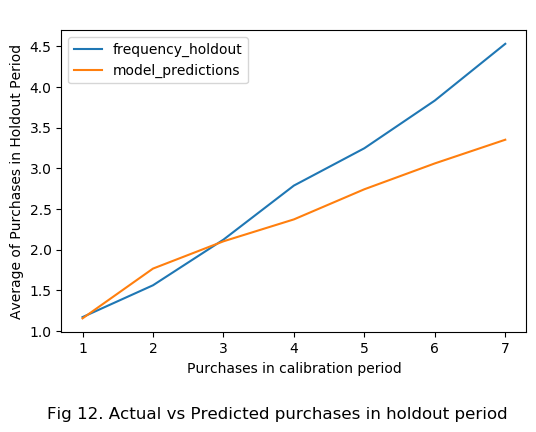

In [276]:
# Plot
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
mpl.rcParams['figure.dpi']= 100
plot_calibration_purchases_vs_holdout_purchases(bgnbd, summary_df);
plt.title(" ");
plt.text(s="Fig 12. Actual vs Predicted purchases in holdout period",x=0.5,y=-0.08,fontsize=12);
plt.savefig('output_83_0.pdf',bbox_inches="tight")

The model systematically underpredicts holdout frequency for customers with >3 frequency in the calibration period. The overall RMSE in prediction is 2.3 equivalent to a prediction error of 48%:

In [199]:
a1 = np.array(holdout_data['frequency_holdout'])
a2 = np.array(holdout_data['frequency_predicted'])
print('The RMSE for model predictions in the holdout period is: ',np.around(math.sqrt(np.mean(np.square(np.subtract(a1,a2)))),decimals=2))
a3 = np.array(holdout_data[holdout_data['frequency_holdout']>0]['frequency_holdout'])
a4 = np.array(holdout_data[holdout_data['frequency_holdout']>0]['frequency_predicted'])
print('The Mean Absolute Percentage Error for model predictions in the holdout period is: ',np.around(np.mean(np.divide(abs(np.subtract(a3,a4))*100,a3))),'%')

The RMSE for model predictions in the holdout period is:  2.3
The Mean Absolute Percentage Error for model predictions in the holdout period is:  48.0 %


### Baseline

For baselining, the holdout visits are projected based on the visits per unit time in the calibration period. 

In [236]:
cal_df.reset_index(inplace=True)
holdout_data['BaselineExpVisits_holdout'] = cal_df['actual_calibration_visits']*t_days/cal_df['T_cal']
a2 = np.array(holdout_data['BaselineExpVisits_holdout'])
a4 = np.array(holdout_data[holdout_data['frequency_holdout']>0]['BaselineExpVisits_holdout'])
print('The RMSE for baseline predictions in the holdout period is: ',np.around(math.sqrt(np.mean(np.square(np.subtract(a1,a2)))),decimals=2))
print('The Mean Absolute Percentage Error for Baseline predictions in the holdout period is: ',np.around(np.mean(np.divide(abs(np.subtract(a3,a4))*100,a3))),'%')

The RMSE for baseline predictions in the holdout period is:  2.42
The Mean Absolute Percentage Error for Baseline predictions in the holdout period is:  68.0 %


## Fit Gamma-Gamma model for average visit spend prediction

In [201]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0.0)
ggf.fit(summary_df['frequency_cal'],
        summary_df['monetary_value_cal'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 1786 subjects, p: 2.50, q: 3.23, v: 370.22>


After fitting the Gamma-Gamma submodel, the estimated parameters are used to get the expected value of mean spend per visit for each customer. 

In [203]:
ExpSpenddf = pd.DataFrame(ggf.conditional_expected_average_profit(summary_df['frequency_cal'],summary_df['monetary_value_cal']))
ExpSpenddf = ExpSpenddf.reset_index()
ExpSpenddf.columns = ExpSpenddf.columns.get_level_values(0)
ExpSpenddf.columns = ['CustomerID','ExpSpendPerVisit']
ExpSpenddf.head()

,CustomerID,ExpSpendPerVisit
0,12347.0,500.572644
1,12348.0,333.448769
2,12352.0,420.123222
3,12356.0,449.915760
4,12359.0,1147.072231


Finally, the expected value of mean spend per visit is multiplied with the expected number of purchases projected by the BG/NBD model to obtain net expected value for each customer.

## Validation

In [237]:
# Calculate the expected net value in holdout
holdout_data = holdout_data.merge(ExpSpenddf,how='left',on='CustomerID')
holdout_data['ExpectedTotalValue'] = holdout_data['frequency_predicted']*holdout_data['ExpSpendPerVisit']
holdout_data.head()

,CustomerID,frequency_cal,frequency_holdout,duration_holdout,monetary_value_holdout,frequency_predicted,BaselineExpVisits_holdout,ExpSpendPerVisit,ExpectedTotalValue
0,12347.0,4.0,2.0,123,759.570000,2.119084,2.500000,500.572644,1060.755387
1,12348.0,2.0,1.0,123,310.000000,1.356512,1.557447,333.448769,452.327202
2,12352.0,3.0,3.0,123,314.743333,1.757650,2.820809,420.123222,738.429379
3,12356.0,1.0,1.0,123,58.350000,0.812331,1.207921,449.915760,365.480524
4,12359.0,2.0,1.0,123,2876.850000,1.556559,1.759615,1147.072231,1785.485679


The observed average spend (i.e. Monetary value) in the holdout period is compared with the Expected mean spend estimated by the model. The null hypothesis $H_0$ being that the sample means are equal. A two-tailed Welch t-test is used. A borderline p-value (0.04) is obtained and thus the null hypothesis cannot be convincingly rejected.

There is an average prediction error of about GBP 200 in the expected spend per visit, which is quite high considering the average spend per visit. However, the distribution of the expected spend per visit fits closely with the observed spend. This means that the model is directionally correct.

In [216]:
from scipy import stats
ObservedMonetaryValue =  holdout_data[(holdout_data['monetary_value_holdout']>0) & (holdout_data['monetary_value_holdout']<1500)]['monetary_value_holdout']
PredictedMonetaryValue =  holdout_data[(holdout_data['monetary_value_holdout']>0) & (holdout_data['monetary_value_holdout']<1500)]['ExpSpendPerVisit']
stats.ttest_ind(ObservedMonetaryValue,PredictedMonetaryValue,equal_var=False)

Ttest_indResult(statistic=2.049278303836273, pvalue=0.04054076520590877)

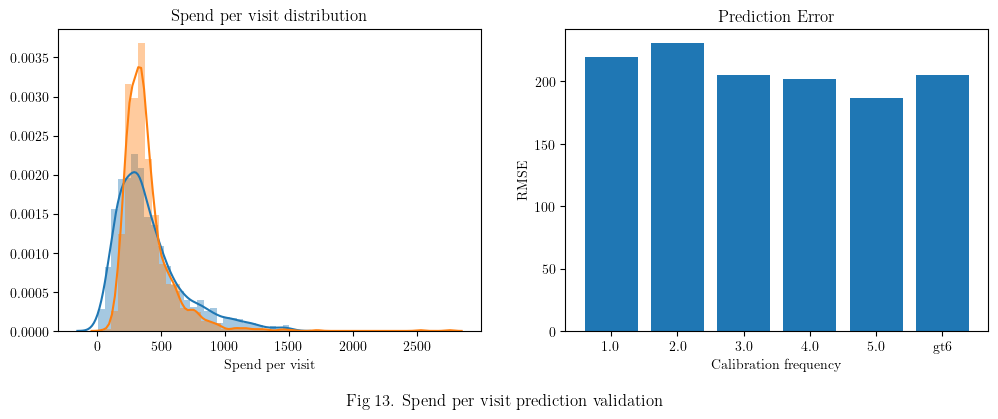

In [279]:
# Plot
mpl.rcParams['figure.dpi']= 100
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plotdf1 = holdout_data[(holdout_data['monetary_value_holdout']>0) & (holdout_data['monetary_value_holdout']<1500)]

fig,axe = plt.subplots(1,2,figsize=(12,4))
sns.distplot(plotdf1['monetary_value_holdout'], label='Observed',ax=axe[0]);
sns.distplot(plotdf1['ExpSpendPerVisit'], label='Expected',ax=axe[0]);
axe[0].set_title("Spend per visit distribution");
axe[0].set_xlabel('Spend per visit');

plotdf1['SE'] = (plotdf1['ExpSpendPerVisit']-plotdf1['monetary_value_holdout'])**2
plotdf1['frequency_cal_bin'] = plotdf1['frequency_cal'].apply(lambda x: 'gt6' if x>=6 else str(x))
plotdf2 = plotdf1.groupby('frequency_cal_bin')[['SE']].mean().reset_index().rename(columns={'SE':'MSE'})
plotdf2['RMSE'] = (plotdf2['MSE'])**(1/2)

axe[1].bar(plotdf2['frequency_cal_bin'],plotdf2['RMSE']);
axe[1].set_title("Prediction Error");
axe[1].set_xlabel("Calibration frequency");
axe[1].set_ylabel("RMSE");
plt.text(s="Fig 13. Spend per visit prediction validation",x=-4,y=-60,fontsize=12);
plt.savefig('output_97_0.pdf',bbox_inches="tight")

In [248]:
display(plotdf2)

,frequency_cal_bin,MSE
0,1.0,48265.771245
1,2.0,53150.151165
2,3.0,42038.177868
3,4.0,40804.648311
4,5.0,34779.101080
5,>=6,41971.296991


# Prioritization using expected future value predictions

One of the primary objectives of predicting future value of a customer is to identify high-value customers and prioritize them for marketing efforts. For the purpose of this exercise, customers with a net spend value > 1000 in the holdout period are flagged as *High Value* customers. The average spend value in the calibration period is used as a "Baseline" model to identify future *High Value* customers. The lift in targeting obtained by using the model predictions vs. the baseline is reported.

In [225]:
# remove this code
def rank_quantile(df,series):
    quantiles = 10
    dummy = df.copy()
    dummy.sort_values(by=[series],ascending=False,inplace=True)
    dummy['rank'] = 1
    n= round(len(df[series])/quantiles)
    i=1
    while(i<=quantiles):
        dummy['rank'][n*(i-1):n*i-1] = i 
        i=i+1
    return dummy['rank']

In [227]:
# Total holdout value - Actual
df_holdout = df[df['InvoiceDate']>pd.to_datetime('2011-08-08',format='%Y-%m-%d')]
actual_val_holdout = df_holdout.groupby(['CustomerID'])[['Sales']].sum().reset_index().rename(columns={'Sales':'ActualValue'})
actual_val_holdout['HighValueCustomer'] = actual_val_holdout['ActualValue'].apply(lambda x: 1 if x>1000 else 0)
# Calculate average spend value in the calibration period
df_cal_summary = input_tran.groupby(['CustomerID']).agg({'Sales':'sum','InvoiceDate':'nunique'}).reset_index()
df_cal_summary.columns = df_cal_summary.columns.get_level_values(0)
df_cal_summary.columns = ['CustomerID','TotalSpendCal','TotalVisitsCal']
df_cal_summary['SpendPerVisit_Cal'] = df_cal_summary['TotalSpendCal']/df_cal_summary['TotalVisitsCal']
# Merge 
liftdata = holdout_data[['CustomerID','ExpectedTotalValue']]
liftdata = liftdata.merge(actual_val_holdout[['CustomerID','HighValueCustomer']],how='left',on='CustomerID').merge(df_cal_summary[['CustomerID','SpendPerVisit_Cal']],how='left',on='CustomerID')
# Create deciles based on model and baseline predictions
liftdata['decile_model'] = rank_quantile(liftdata,'ExpectedTotalValue')
liftdata['decile_baseline'] = rank_quantile(liftdata,'SpendPerVisit_Cal')
liftdata.head()

,CustomerID,ExpectedTotalValue,HighValueCustomer,SpendPerVisit_Cal,decile_model,decile_baseline
0,12347.0,1060.755387,1.0,615.714286,3,2
1,12348.0,452.327202,0.0,449.310000,7,3
2,12352.0,738.429379,0.0,358.005714,4,5
3,12356.0,365.480524,0.0,937.143333,8,1
4,12359.0,1785.485679,1.0,1593.145000,1,1


## Lift

The model lift is now calculated based on the cumulative proportion of true high value customers captured with population.

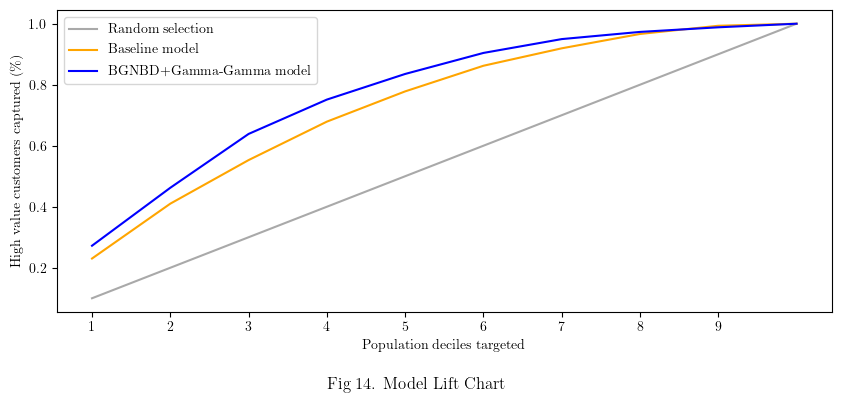

In [281]:
#Plot
mpl.rcParams['figure.dpi']= 100
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.figure(figsize=(10,4))

plotdf1 = liftdata.groupby('decile_model')[['HighValueCustomer']].sum().reset_index().rename(columns={'HighValueCustomer':'cnt_highvalue'})
plotdf1['cumcnt_highvalue'] = plotdf1['cnt_highvalue'].cumsum()
plotdf1['eventratemodel'] = plotdf1['cumcnt_highvalue']/(plotdf1['cnt_highvalue'].sum())

plotdf2 = liftdata.groupby('decile_baseline')[['HighValueCustomer']].sum().reset_index().rename(columns={'HighValueCustomer':'cnt_highvalue'})
plotdf2['cumcnt_highvalue'] = plotdf2['cnt_highvalue'].cumsum()
plotdf2['eventratebaseline'] = plotdf2['cumcnt_highvalue']/(plotdf2['cnt_highvalue'].sum())

plotdf = pd.merge(plotdf1[['decile_model','eventratemodel']].rename(columns={'decile_model':'decile'}), \
                  plotdf2[['decile_baseline','eventratebaseline']].rename(columns={'decile_baseline':'decile'}),how='inner',on='decile')
plotdf['eventraterandom'] = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

sns.lineplot(x=plotdf["decile"], y=plotdf["eventraterandom"],color = 'darkgrey',label='Random selection');
sns.lineplot(x=plotdf["decile"], y=plotdf["eventratebaseline"],color = 'orange',label='Baseline model');
sns.lineplot(x=plotdf["decile"], y=plotdf["eventratemodel"],color = 'blue',label='BGNBD+Gamma-Gamma model');
plt.xlabel("Population deciles targeted");
plt.ylabel("High value customers captured (\%)");
plt.xticks(np.arange(1,10,1));

plt.text(s="Fig 14. Model Lift Chart",x=4,y=-0.2,fontsize=12);
plt.savefig('output_105_0.pdf',bbox_inches="tight")

**Interpretation**

If customers are segmented into priority deciles based on the model predictions, then targeting the top 4 deciles - 40% of the popuation - will capture about 75% of the true high value customers. This results in a lift of 1.87 compared to random selection. The lift obtained compared to the baseline model is 11%.

# Results

The BG/NBD model projects the expected number of visits in the future period with an error margin of 48%. The error margin is 68% if projections are made by extrapolating the average calibration frequency (Baseline model). The errors in prediction can be reduced with longer calibration period lengths. 

The Gamma-Gamma model predicts the expected spend per visit for each customer. The error in model prediction is about GBP 200 compared to the observed spend per visit in the holdout sample. 

Together, the expected number of visits is multiplied by the expected spend per visit to project the net expected value for each customer in the holdout period. The model predictions provide a lift of 187% compared to random selection and 11% compared to the baseline model in capturing *High value customers* in the first 4 deciles (i.e. 40% of the population). This result is satisfactory and can be useful in correctly prioritizing customers for future investments. 

# To-do notes

1. Captions in all plots
2. Hyper link to Fader's paper in the first mention under the "Theory" section